 # Catálogo variables
 
 **Dependent variable:**

* _MICHD - Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI);

**Independent variables:**

* _BMI5 - Body Mass Index (BMI);
* SMOKE100 - Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes];
* _RFDRHV7 - Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week);
* CVDSTRK3 - (Ever told) (you had) a stroke;
* PHYSHLTH - Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good?;
* MENTHLTH - Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good?;
* DIFFWALK - Do you have serious difficulty walking or climbing stairs?;
* SEXVAR - Are you male or female?;
* _AGEG5YR - Fourteen-level age category;
* _IMPRACE - Imputed race/ethnicity value (This value is the reported race/ethnicity or an imputed race/ethnicity, if the respondent refused to give a race/ethnicity. The value of the imputed race/ethnicity will be the most common race/ethnicity response for that region of the state) 7;
* DIABETE4 - (Ever told) (you had) diabetes? (If ´Yes´ and respondent is female, ask ´Was this only when you were pregnant?´. If Respondent says pre-diabetes or borderline diabetes, use response code 4.);
* _TOTINDA - Adults who reported doing physical activity or exercise during the past 30 days other than their regular job;
* GENHLTH - Would you say that in general your health is;
* SLEPTIM1 - On average, how many hours of sleep do you get in a 24-hour period?;
* ASTHMA3 - (Ever told) (you had) asthma?;
* CHCKDNY2 - Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?;
* CHCSCNCR - (Ever told) (you had) skin cancer?

In [18]:
import pandas as pd
import numpy as np 
from sty import bg, fg,rs
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import re
import missingno as msno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
################################################ FILTER WARNINGS #################################################
import warnings
warnings.filterwarnings("ignore")


from xgboost import XGBClassifier

> https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf

> https://www.kaggle.com/code/nkitgupta/advance-data-preprocessing

> https://www.kaggle.com/code/luanrd/hyperparameters-optimization-for-diferent-models

> https://www.kaggle.com/code/vsevolodcherepanov/short-xgbc-test-cross-val-accuracy-0-916

In [4]:
data_folder = 'data/heart_2020.csv'
work_dir = os.getcwd()
parent_dir = os.path.dirname(os.path.normpath(work_dir))
data_dir = os.path.join(parent_dir,data_folder)
df = pd.read_csv(data_dir)


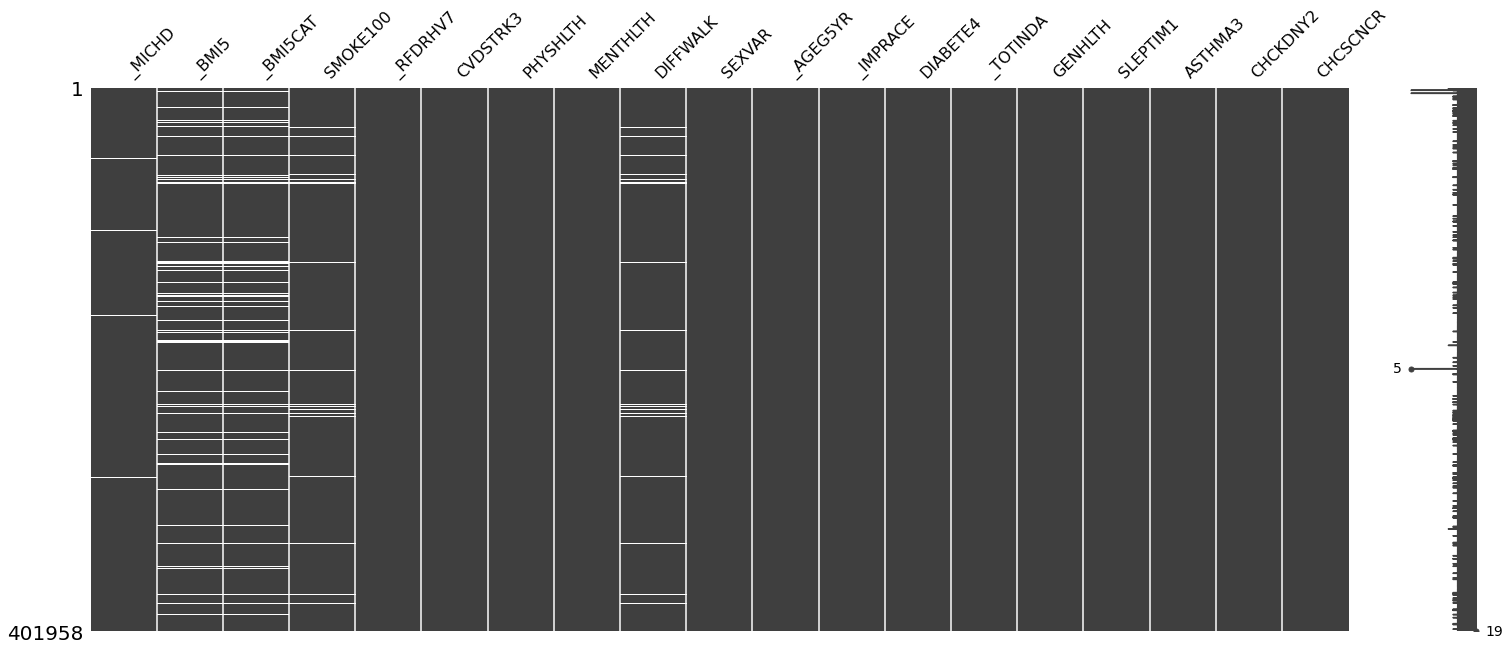

<Figure size 1080x648 with 0 Axes>

In [5]:
# Representamos los nulos gráficamente
msno.matrix(df[["_MICHD", "_BMI5","_BMI5CAT", "SMOKE100", "_RFDRHV7", "CVDSTRK3", "PHYSHLTH",
             "MENTHLTH", "DIFFWALK", "SEXVAR", "_AGEG5YR", "_IMPRACE", "DIABETE4",
            "_TOTINDA", "GENHLTH", "SLEPTIM1", "ASTHMA3", "CHCKDNY2", "CHCSCNCR"]])
plt.figure(figsize = (15,9))
plt.show()


In [6]:
class NameDropper(BaseEstimator,TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        columns     = ["_MICHD", "_BMI5","_BMI5CAT", "SMOKE100", "_RFDRHV7", "CVDSTRK3", "PHYSHLTH",
             "MENTHLTH", "DIFFWALK", "SEXVAR", "_AGEG5YR", "_IMPRACE", "DIABETE4",
            "_TOTINDA", "GENHLTH", "SLEPTIM1", "ASTHMA3", "CHCKDNY2", "CHCSCNCR"]
        try:
            assert type(columns) == list ,   "Proporciona una lista de Variables presente en el Dataset"
            assert type(X) == pd.DataFrame , "Proporciona un Dataframe de pandas"
            return X[columns]
        except AssertionError as msg:
            print(msg)


class Transformer(BaseEstimator,TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        '''renaming
           dropping na
           recodification '''
        try:
            X["_MICHD"] = X["_MICHD"].replace({2: "No", 1: "Yes"})

            X["_BMI5CAT"] = X["_BMI5CAT"].replace({
                1: "Underweight (BMI < 18.5)",
                2: "Normal weight (18.5 <= BMI < 25.0)",
                3: "Overweight (25.0 <= BMI < 30.0)",
                4: "Obese (30.0 <= BMI < +Inf)"
            })

            binary_vars = ["SMOKE100", "CVDSTRK3", "DIFFWALK", "_TOTINDA", "ASTHMA3", "CHCKDNY2", "CHCSCNCR"]
            X[binary_vars] = X[binary_vars].replace({
                1: "Yes",
                2: "No",
                7: np.NaN,
                9: np.NaN
            })

            X["_RFDRHV7"] = X["_RFDRHV7"].replace({
                1: "No",
                2: "Yes",
                9: np.NaN
            })

            multi_vars = ["PHYSHLTH", "MENTHLTH"]
            X[multi_vars] = X[multi_vars].replace({
                88: 0,
                77: np.NaN,
                99: np.NaN
            })

            X["SEXVAR"] = X["SEXVAR"].replace({1: "Male", 2: "Female"})

            X["_AGEG5YR"] = X["_AGEG5YR"].replace({
                1: "18-24",
                2: "25-29",
                3: "30-34",
                4: "35-39",
                5: "40-44",
                6: "45-49",
                7: "50-54",
                8: "55-59",
                9: "60-64",
                10: "65-69",
                11: "70-74",
                12: "75-79",
                13: "80 or older",
                14: np.NaN
            })

            X["_IMPRACE"] = X["_IMPRACE"].replace({
                1: "White",
                2: "Black",
                3: "Asian",
                4: "American Indian/Alaskan Native",
                5: "Hispanic",
                6: "Other"
            })

            X["DIABETE4"] = X["DIABETE4"].replace({
                1: "Yes",
                2: "Yes (during pregnancy)",
                3: "No",
                4: "No, borderline diabetes",
                7: np.NaN,
                9: np.NaN
            })

            X["GENHLTH"] = X["GENHLTH"].replace({
                1: "Excellent",
                2: "Very good",
                3: "Good",
                4: "Fair",
                5: "Poor",
                7: np.NaN,
                9: np.NaN
            })

            X["SLEPTIM1"] = X["SLEPTIM1"].replace({
                77: np.NaN,
                99: np.NaN
            })
            X = X.dropna()
            X = X.rename({
                        "_MICHD": "HeartDisease",
                        "_BMI5CAT": "BMICategory",
                        "SMOKE100": "Smoking",
                        "_RFDRHV7": "AlcoholDrinking",
                        "CVDSTRK3": "Stroke",
                        "PHYSHLTH": "PhysicalHealth",
                        "MENTHLTH": "MentalHealth",
                        "DIFFWALK": "DiffWalking",
                        "SEXVAR": "Sex",
                        "_AGEG5YR": "AgeCategory",
                        "_IMPRACE": "Race",
                        "DIABETE4": "Diabetic",
                        "_TOTINDA": "PhysicalActivity",
                        "GENHLTH": "GenHealth",
                        "SLEPTIM1": "SleepTime",
                        "ASTHMA3": "Asthma",
                        "CHCKDNY2": "KidneyDisease",
                        "CHCSCNCR": "SkinCancer"
                            }, axis=1)
            #X["HeartDisease"] = X["HeartDisease"].replace({"No": 0, "Yes": 1})
            #X = pd.get_dummies(X[1:])
            return X

        except Exception as msg:
            print(msg)

In [7]:
pipe = Pipeline([
      ('dropper' ,      NameDropper()),
      ('transformer' ,  Transformer())
])

df = pipe.fit_transform(df)

In [8]:
print('number of rows:', df.shape[0])
print('number of columns:', df.shape[1])

number of rows: 319795
number of columns: 19


In [9]:
#Contamos los valores del target y detectamos que es un set desbalanceado de datos.
df.HeartDisease.value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [11]:
pd.DataFrame(df['AgeCategory'].value_counts()).style.bar(color='navajowhite')

,AgeCategory
65-69,34151
60-64,33686
70-74,31065
55-59,29757
50-54,25382
80 or older,24153
45-49,21791
75-79,21482
18-24,21064
40-44,21006


<AxesSubplot:>

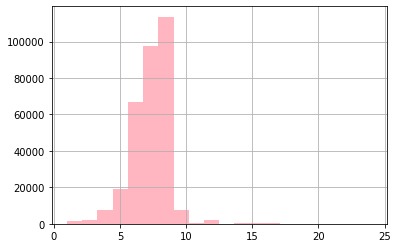

In [19]:
df['SleepTime'].hist(bins = 20, color = 'lightpink')